Unzip the data

In [ ]:
import zipfile
path_to_zip_file = 'data.zip'
directory_to_extract_to = './data/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Helper functions, Quality Annotation, Peak Valley Detection, Feature computation

In [10]:
import os
import pandas as pd
from tomkin import detect_rpeak
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from outlier_calculation import Quality,compute_outlier_ecg
from joblib import Parallel,delayed
from data_quality import ECGQualityCalculation
from joblib import delayed,Parallel
from copy import deepcopy
from ecg import ecg_feature_computation
from scipy import interpolate
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
import gzip
# from peak_valley import compute_peak_valley

def get_interpolated(aclx,acly,aclz):
    time_array = aclx[:,1].reshape(-1,1)
    aclxyz = np.concatenate([time_array,time_array,time_array,time_array],axis=1)
    f = interpolate.interp1d(aclx[:,1],aclx[:,0],fill_value='extrapolate')
    aclxyz[:,1] = f(aclxyz[:,0])
    f = interpolate.interp1d(acly[:,1],acly[:,0],fill_value='extrapolate')
    aclxyz[:,2] = f(aclxyz[:,0])
    f = interpolate.interp1d(aclz[:,1],aclz[:,0],fill_value='extrapolate')
    aclxyz[:,3] = f(aclxyz[:,0])
    return aclxyz

def get_quality(data):
    outlier_threshold_high = 4000
    outlier_threshold_low = 20
    slope_threshold = 300
    eck_threshold_band_loose = 175
    eck_threshold_band_off = 20
    minimum_expected_samples = 3*(0.33)*21.33
    data_quality_band_loose = 0
    data_quality_not_worn = 0
    data_quality_band_off = 0
    data_quality_missing = 0 
    data_quality_good = 1
    acceptable_outlier_percent = 34
    
    if (len(data)== 0):
        return data_quality_band_off
    range_data = max(data)-min(data)
    if range_data<=eck_threshold_band_off:
        return data_quality_not_worn
    if (len(data)<=minimum_expected_samples) :
        return data_quality_missing
    if range_data<=eck_threshold_band_loose:
        return data_quality_band_loose
    
    outlier_counts = 0 
    for i in range(0,len(data)):
        im,ip  = i,i
        if i==0:
            im = len(data)-1
        else:
            im = i-1
        if i == len(data)-1:
            ip = 0
        else:
            ip = ip+1
        stuck = ((data[i]==data[im]) and (data[i]==data[ip]))
        flip = ((abs(data[i]-data[im])>((int(outlier_threshold_high)))) or (abs(data[i]-data[ip])>((int(outlier_threshold_high)))))
        disc = ((abs(data[i]-data[im])>((int(slope_threshold)))) and (abs(data[i]-data[ip])>((int(slope_threshold)))))
        if disc:
            outlier_counts += 1
        elif stuck:
            outlier_counts +=1
        elif flip:
            outlier_counts +=1
        elif data[i] >= outlier_threshold_high:
            outlier_counts +=1
        elif data[i]<= outlier_threshold_low:
            outlier_counts +=1
    if (100*outlier_counts>acceptable_outlier_percent*len(data)):
        return data_quality_band_loose
    return data_quality_good

def get_clean_ecg(ecg_data):
    final_data = np.zeros((0,3))
    if len(ecg_data)==0:
        return final_data
    test_object = ECGQualityCalculation()
    start_ts = ecg_data[0,0]
    final_data = np.zeros((0,3))
    while start_ts<ecg_data[-1,0]:
        index = np.where((ecg_data[:,0]>=start_ts)&(ecg_data[:,0]<start_ts+3000))[0]
        temp_data = ecg_data[index,2]
        if test_object.current_quality(temp_data)==1:
            final_data = np.concatenate((final_data,ecg_data[index,:]))
        start_ts = start_ts + 3000
    return final_data

def get_clean_rip(rip_data):
    if len(rip_data)==0:
        return final_data
    i = 0
    final_data = np.zeros((0,2))
    while i<len(rip_data):
        j = i
        index = []
        while j<len(rip_data) and rip_data[j,0] - rip_data[i,0] <= 3000:
            index.append(j)
            j+=1
        i=j+1
        temp_data = rip_data[np.array(index),1]
        if get_quality(temp_data)==1:
            final_data = np.concatenate((final_data,rip_data[np.array(index),:]))
    return final_data

def get_hr(ecg_data):
#     try:
    rpeaks = detect_rpeak(ecg_data[:,2],64)
    rpeak_ts = ecg_data[rpeaks,0]
    ecg_rr = np.zeros((len(rpeaks)-1,2))
    ecg_rr_ts = np.array(rpeak_ts)[1:]
    ecg_rr_sample = np.array(np.diff(rpeak_ts))
    index = np.where((ecg_rr_sample>=300)&(ecg_rr_sample<=2000))[0]
    ecg_rr_ts = ecg_rr_ts[index]
    ecg_rr_sam = ecg_rr_sample[index]
    rr = remove_ectopic_beats(ecg_rr_sam)
    ecg_rr_sam = ecg_rr_sam[~np.isnan(rr)]
    ecg_rr_ts = ecg_rr_ts[~np.isnan(rr)]
    outlier = compute_outlier_ecg(ecg_rr_ts/1000,ecg_rr_sam/1000)
    ind1 = []
    for ind,tup in enumerate(outlier):
        if tup[1]==Quality.ACCEPTABLE:
            ind1.append(ind)
    ind1 = np.array(ind1)
    if len(ind1)<100:
        return [],[]
    ecg_rr_ts = ecg_rr_ts[ind1]
    ecg_rr_sam = ecg_rr_sam[ind1]
    return ecg_rr_ts,ecg_rr_sam
#     except Exception as e:
#         print(e)
def get_windows(data,window_size=10,offset=10,fs=1):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>t-window_size*1000/2)&(data[:,0]<=t+window_size*1000/2))[0]
        if len(index)<50:
            continue
        window_col.append(data[index,:])
    return window_col

def get_rip_windows(data,window_size=60,offset=10,fs=.2):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>=t-window_size*1000/2)&(data[:,1]<=t+window_size*1000/2))[0]
        if len(index)<10:
            continue
        window_col.append(data[index,:])
    return window_col


from peak_valley import compute_peak_valley,rip_cycle_feature_computation
from scipy import stats

def get_std_chest(window,start=1,end=4):
    return np.array([np.mean(window[:,0]),np.sqrt(np.sum(np.power(np.std(window[:,start:end],axis=0),2)))])
def filter_ecg_windows(ecg_windows,acl_std):
    final_ecg_windows = []
    for window in ecg_windows:
        index = np.where((acl_std[:,0]>window[0,0])&(acl_std[:,0]<window[-1,0]))[0]
        if len(index)==0:
            continue
        window_temp = acl_std[index,1].reshape(-1)
        if len(window_temp[window_temp>.21])/len(window_temp) > .5:
            continue
        final_ecg_windows.append(window)
    return final_ecg_windows



Parse the data

In [2]:
path = './data/'
participants = [path + f +'/' for f in os.listdir(path) if f[0]=='S']
count=0
for f in participants:
    try:
        rip = pd.read_csv(f  +'rip.txt.gz', compression='gzip',
                          sep=' ',header=None).values
        a = deepcopy(rip[:,0])
        rip[:,0] = rip[:,1]
        rip[:,1] = a
    except Exception as e:
        continue
    count+=1
    rip_data = get_clean_rip(rip)
    pickle.dump(rip_data,open(f+'rip.p','wb'))
    rip = pickle.load(open(f+'rip.p','rb'))
    
    peaks,valleys = compute_peak_valley(rip)
    print(peaks.shape,valleys.shape,peaks[:2])
    pickle.dump([peaks,valleys],open(f+'pv.p','wb'))

(2383, 2) (2383, 2) [[1.26581909e+12 3.62260000e+03]
 [1.26581909e+12 3.16100000e+03]]
(2413, 2) (2413, 2) [[1.26590182e+12 3.53160000e+03]
 [1.26590183e+12 4.36460000e+03]]
(2292, 2) (2292, 2) [[1.2666106e+12 2.6788000e+03]
 [1.2666106e+12 2.4176000e+03]]
(2934, 2) (2934, 2) [[1.26600814e+12 2.70200000e+03]
 [1.26600814e+12 3.56440000e+03]]
(1999, 2) (1999, 2) [[1.26624757e+12 2.60820000e+03]
 [1.26624757e+12 2.75880000e+03]]
(2457, 2) (2457, 2) [[1.26641774e+12 2.68240000e+03]
 [1.26641774e+12 2.88080000e+03]]
(1886, 2) (1886, 2) [[1.26650994e+12 2.87820000e+03]
 [1.26650994e+12 2.69680000e+03]]
(2439, 2) (2439, 2) [[1.26747931e+12 2.79680000e+03]
 [1.26747931e+12 3.25300000e+03]]
(2628, 2) (2628, 2) [[1.26685683e+12 3.04800000e+03]
 [1.26685683e+12 3.09340000e+03]]
(2267, 2) (2267, 2) [[1.26693574e+12 2.66360000e+03]
 [1.26693574e+12 3.20480000e+03]]
(2156, 2) (2156, 2) [[1.26696208e+12 3.05300000e+03]
 [1.26696208e+12 2.72820000e+03]]
(2281, 2) (2281, 2) [[1.26702173e+12 3.64040000

Standardize the features

In [11]:
path = './data/'
participants = [path + f +'/' for f in os.listdir(path) if f[0]=='S']
count=0
for f in participants[::-1]: 
    if 'pv.p' not in os.listdir(f) or 'stress_marks.txt.gz' not in os.listdir(f):
        continue
    st = 0
    et = 0 
    with gzip.open(f+'stress_marks.txt.gz', 'r') as file:
        for line in file.readlines():
            line = line.decode('utf8').strip()
            parts = [x.strip() for x in line.split(',')]
            label = parts[0]
            if label[:2] in ['c1']:
                st = np.int64(parts[2])
                et = np.int64(parts[3])

    peaks,valleys = pickle.load(open(f+'pv.p','rb'))
    rip_features = rip_cycle_feature_computation(peaks,valleys)
    rip_features = rip_features[:,np.array([0,1,2,3,4,5,6,-2,-1])]
    for c in range(2,rip_features.shape[1]):
        rip_features[:,c] = stats.mstats.winsorize(rip_features[:,c],limits=.1)
    rip_windows = get_rip_windows(rip_features,window_size=60,offset=30,fs=1)
    rip_features_minute = np.array([np.array([window[0,0],window[-1,1]]+
                                              list(np.mean(window[:,2:],axis=0))+
                                              list(np.std(window[:,2:],axis=0))+
                                              list(np.percentile(window[:,2:],80,axis=0))+
                                              list(np.percentile(window[:,2:],20,axis=0)))  for window 
                                              in rip_windows])
    rip_features_minute[:,2:] =StandardScaler().fit_transform(rip_features_minute[:,2:])
    print(rip_features_minute.shape)
    pickle.dump(rip_features_minute,open(f+'features_rip2.p','wb'))

(209, 30)
(250, 30)
(229, 30)
(263, 30)
(216, 30)
(256, 30)
(271, 30)
(201, 30)
(269, 30)
(255, 30)
(259, 30)
(293, 30)
(264, 30)
(233, 30)
(274, 30)
(255, 30)
(306, 30)
(240, 30)
(256, 30)
(255, 30)


Annotate each feature row with stress/not stress

In [13]:
# Soujanya Chatterjee
	
# 2:06 PM (9 minutes ago)
	
# to me
import pandas as pd, numpy as np, os, csv, glob, math, matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from scipy.stats import *
import gzip
import pickle
from collections import Counter

def find_majority(k):
    myMap = {}
    maximum = ( '', 0 ) # (occurring element, occurrences)
    for n in k:
        if n in myMap: myMap[n] += 1
        else: myMap[n] = 1

        # Keep track of maximum on the go
        if myMap[n] > maximum[1]: maximum = (n,myMap[n])

    return maximum[0]

# _dir = 'W:\\Students\\cstress_features\\data\\data\\SI02\\'

def decodeLabel(label):
    label = label[:2]  # Only the first 2 characters designate the label code

    mapping = {'c1': 0, 'c2': 1, 'c3': 1, 'c4': 0, 'c5': 0, 'c6': 0, 'c7': 2}

    return mapping[label]

def readstressmarks(participantID, filename):
    features = []
    for file in os.listdir(filename):    
        if file.endswith("marks.txt.gz"):        
            with gzip.open(os.path.join(filename, file), 'r') as file:
                for line in file.readlines():
                    line = line.decode('utf8').strip()
                    parts = [x.strip() for x in line.split(',')]                    
                    label = parts[0][:2]  
                    if label not in ['c7','c6']:
                        stressClass = decodeLabel(label)
                        features.append([participantID, stressClass, int(parts[2]), int(parts[3])])
    return np.array(features)
_dirr = './data/'
parti = np.array(os.listdir(_dirr) )
header = ['participant','starttime','endtime','label'] + ['f_'+str(i) for i in range(28)]
fea_cols = ['f_'+str(i) for i in range(28)]
data = []
for p in parti:
    print(p)
    if p in ['feature.csv','feature_ecg.csv','feature_rip.csv',
             'SI09','SI23','SI24','.ipynb_checkpoints']:
        continue
    else:
        if os.path.isdir(os.path.join(_dirr,p)):
           
            _dir = (os.path.join(_dirr,p))
            gt_marks = readstressmarks(p,_dir)
            groundtruth = pd.DataFrame({'participant': gt_marks[:, 0], 'label': gt_marks[:, 1], 'starttime': gt_marks[:, 2],
                                        'endtime': gt_marks[:, 3]}, columns=['participant','label','starttime','endtime'])
            groundtruth = groundtruth.sort_values('starttime')
   
            check = False
            for file in os.listdir(_dir):    
                    if file.endswith("features_rip2.p"):                    
                        with open(_dir+'/'+file, 'rb') as f:  
                            x = pickle.load(f)
                            check  =True
            if not check:
                continue
#             print(x.shape)
#             dataset = pd.DataFrame({'starttime': x[:, 0], 'endtime': x[:, 1], 'f_1': x[:, 2]
#                                    , 'f_2': x[:, 3], 'f_3': x[:, 4], 'f_4': x[:, 5]
#                                    , 'f_5': x[:, 6], 'f_6': x[:, 7], 'f_7': x[:, 8]
#                                    , 'f_8': x[:, 9], 'f_9': x[:, 10], 'f_10': x[:, 11]
#                                    , 'f_11': x[:, 12]}, columns=['starttime','endtime','f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8',
#                                                                  'f_9','f_10','f_11'])

            dataset = pd.DataFrame(x,columns=['starttime','endtime']+['f_'+str(i) for i in range(x.shape[1]-2)])
            dataset = dataset.sort_values('starttime')

            for gt in range(len(dataset)):
                starttime = int(dataset['starttime'].iloc[gt])
                endtime = int(dataset['endtime'].iloc[gt])
                result = []
                for line in range(len(groundtruth)):
                    id, gtt, st, et = [groundtruth['participant'].iloc[line], groundtruth['label'].iloc[line], int(groundtruth['starttime'].iloc[line]),
                                      int(groundtruth['endtime'].iloc[line])]
                    if starttime < st:
                        continue
                    else:
                        if (starttime > st) and (endtime < et):
                            result.append(gtt)
                        if result:
                            fea = list(dataset[fea_cols].iloc[gt])
                            inter_data = [p, st,et,find_majority(result)],(fea)
                            flatten = lambda l: [item for sublist in l for item in sublist]

                            data.append(flatten(inter_data))

df = pd.DataFrame(data)
df.to_csv(_dirr + '/' + 'feature_rip.csv', index=False, header=header)
df.shape

.DS_Store
SI01
SI02
SI03
SI04
SI05
SI06
SI07
SI08
SI09
SI10
SI11
SI12
SI13
SI14
SI15
SI16
SI17
SI18
SI19
SI20
SI21
SI22
SI23
SI24
.ipynb_checkpoints
feature.csv
feature_rip.csv
feature_ecg.csv
feature_all.csv
feature_rip_ecg.csv


(2789, 32)

Read the saved feature matrix

In [14]:
feature_file = './data/feature_rip.csv'
feature = pd.read_csv(feature_file).values
y = np.int64(feature[:,3])
X = feature[:,4:]
print(X.shape,y.shape,np.sum(y),np.unique(y))
groups = feature[:,0]

(2789, 28) (2789,) 535 [0 1]


Leave one Subject Out Cross Validation

In [15]:
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed

delta = 0.1

paramGrid = {
             'rf__kernel': ['rbf'],
             'rf__C': np.logspace(.1,4,5),
             'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-4, 4, .5)],
             'rf__class_weight': [{0: w, 1: 1 - w} for w in [.4,.3,.2]],
             'rf__probability':[True]
}
clf = Pipeline([('pca',PCA(n_components=4)),('rf', SVC())])
# clf = SVC()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                           scoring='f1_weighted',verbose=5)
grid_search.fit(X,y)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
clf = grid_search.best_estimator_
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups))
print(confusion_matrix(y,y_pred),classification_report(y,y_pred))

Fitting 20 folds for each of 240 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2082 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2946 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4512 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 |

Best parameter (CV score=0.898):
{'rf__C': 1.2589254117941673, 'rf__class_weight': {0: 0.4, 1: 0.6}, 'rf__gamma': 0.08838834764831845, 'rf__kernel': 'rbf', 'rf__probability': True}
[[2078  176]
 [ 114  421]]               precision    recall  f1-score   support

           0       0.95      0.92      0.93      2254
           1       0.71      0.79      0.74       535

    accuracy                           0.90      2789
   macro avg       0.83      0.85      0.84      2789
weighted avg       0.90      0.90      0.90      2789



Save the model

In [8]:
import pickle
print(clf)
clf.fit(X,y)
# pickle.dump(clf,open('/home/jupyter/mullah/cc3/rip_model_feature_standardization.p','wb'))

pickle.dump(clf,open('/home/jupyter/mullah/Test/data_yield/cstress_features/models/rip_model.p','wb'))

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=4,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rf',
                 SVC(C=1.2589254117941673, break_ties=False, cache_size=200,
                     class_weight={0: 0.4, 1: 0.6}, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.0625,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


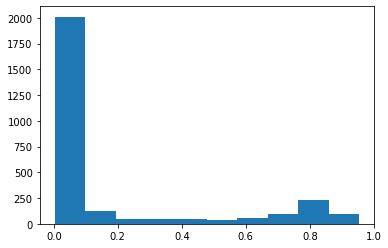

In [16]:
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),method='predict_proba')[:,1]
# print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
plt.hist(y_pred)
plt.show()